In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym

In [2]:
from arcle.loaders import ARCLoader, MiniARCLoader

In [3]:
from policies.Mark_I_DTPolicy import Mark_I_DTPolicy, Config
from envs.NonSparseO2ARCv2Env import NonSparseO2ARCv2Env

from utils.preprocessing import Parser, parse_inputs
from utils.data import ContextBuffer
from utils.config import Config
from utils.tracking import EnvironmentCapture, create_animation

In [4]:
CONFIG = Config.from_yaml("./config/config.yaml")

In [5]:
loader = ARCLoader()

In [6]:
model = Mark_I_DTPolicy(CONFIG)
model.to(CONFIG.DEVICE)
None

In [12]:
env_capture = EnvironmentCapture()
env = NonSparseO2ARCv2Env(CONFIG)

obs, info = env.reset(options={'adaptation': True})
# env.init_state(initial_grid=obs['input'], options={'adaptation': True})

context_buffer = ContextBuffer(CONFIG.BLOCK_SIZE)
context = context_buffer.update(parse_inputs(obs['grid'], info['answer'], np.array([0,0,0,0]),CONFIG.NO_OP, 0.0, CONFIG))


for i in tqdm(range(50)):

    op_logits , bbox = model(*context)
    op = op_logits.softmax(dim=-1)[-1,-1,:].argmax()
    sel = Parser.parse_bbox(*bbox[-1,-1,:].detach().cpu().numpy())

    action = {
        'operation': op,
        'selection': sel
    }
    obs, reward, term, trunc, info = env.step(action)


    context = context_buffer.update(parse_inputs(obs['grid'], info['answer'], bbox[-1,-1,:].detach().cpu().numpy(),op, reward, CONFIG))

    env_capture.add_step("state", obs['grid'])
    env_capture.add_step("reward", reward)
    env_capture.add_step("operation", int(action['operation'].detach().cpu()))
    env_capture.add_step("selection", action['selection'])
    # obs, reward, terminated, trunc, info = env.step(action)
    if term or trunc:
        print('!!!!')
        break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.67it/s]


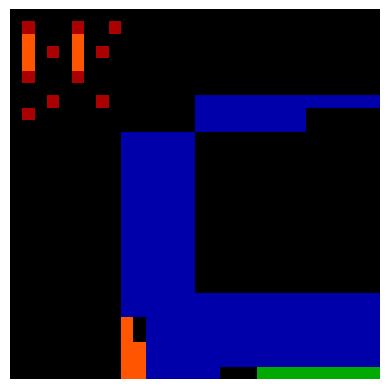

In [16]:
create_animation(env_capture.stack()['state'], save_path='./test.mp4', fps=45)


In [ ]:
function_names = [ f.__name__ for f in env.create_operations()]
print("\n".join([function_names[op] for op in env_capture.stack()['operation'][1:]]))

FloodFill9
FloodFill6
Color0
Color2
FloodFill0
FloodFill0
FloodFill5
resize_grid
FloodFill6
FloodFill6
FloodFill0
FloodFill5
Move_U
FloodFill3
FloodFill5
FloodFill5
FloodFill6
FloodFill0
FloodFill9
FloodFill2
Move_U
Copy_I
FloodFill6
FloodFill5
FloodFill9
FloodFill9
FloodFill2
FloodFill9
Copy_O
FloodFill0
FloodFill9
FloodFill9
FloodFill8
FloodFill9
FloodFill9
FloodFill9
Move_L
Flip_V
FloodFill6
FloodFill9
FloodFill9
Color7
Move_L
FloodFill6
FloodFill9
FloodFill6
FloodFill9
Color3
FloodFill5
